In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,Dense,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset,dataset_info = tfds.load(
                                  'malaria',
                                  with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train']
                                )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteCOL7Z8/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0 , label
dataset[0] = dataset[0].map(resize_rescale)
dataset[0] = dataset[0].shuffle(buffer_size=1024,reshuffle_each_iteration=True).batch(32)

In [4]:
def dataset_split(dataset,Train_Ratio,Val_Ratio,Test_Ratio):
  Dataset_Size = len(dataset)
  train_dataset = dataset.take(int(Dataset_Size*Train_Ratio))
  val_dataset = dataset.skip(int(Dataset_Size*Train_Ratio)).take(int(Dataset_Size*Val_Ratio))
  test_dataset = dataset.skip(int(Dataset_Size*Train_Ratio)).skip(int(Dataset_Size*Val_Ratio)).take(int(Dataset_Size*Test_Ratio))

  return train_dataset,val_dataset,test_dataset


In [5]:
train_dataset,val_dataset,test_dataset = dataset_split(dataset[0],0.8,0.1,0.1)

In [6]:
# for i,(image,label) in enumerate(train_dataset.take(16)):
#   plt.subplot(4,4,i+1)
#   plt.imshow(image)
#   plt.title(dataset_info.features['label'].int2str(label))
#   plt.axis('off')

In [7]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [9]:
test_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [10]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters=6,kernel_size=3,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Conv2D(filters=16,kernel_size=3,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Flatten(),

    Dense(100,activation="relu"),
    BatchNormalization(),

    Dense(10,activation="relu"),
    BatchNormalization(),

    Dense(1,activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [11]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics="accuracy"
              )

In [12]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 107s 133ms/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 3.8195 - val_accuracy: 0.5371
Epoch 2/20
689/689 [==============================] - 55s 78ms/step - loss: 0.2260 - accuracy: 0.9228 - val_loss: 0.4659 - val_accuracy: 0.7126
Epoch 3/20
689/689 [==============================] - 71s 101ms/step - loss: 0.2134 - accuracy: 0.9269 - val_loss: 0.7760 - val_accuracy: 0.8423
Epoch 4/20
689/689 [==============================] - 54s 76ms/step - loss: 0.1877 - accuracy: 0.9365 - val_loss: 0.1879 - val_accuracy: 0.9408
Epoch 5/20
689/689 [==============================] - 54s 77ms/step - loss: 0.1782 - accuracy: 0.9399 - val_loss: 4.6022 - val_accuracy: 0.8387
Epoch 6/20
689/689 [==============================] - 55s 78ms/step - loss: 0.1662 - accuracy: 0.9435 - val_loss: 0.3235 - val_accuracy: 0.9157
Epoch 7/20
689/689 [==============================] - 56s 80ms/step - loss: 0.1581 - accuracy: 0.9475 - val_loss: 0.1684 - val_accura

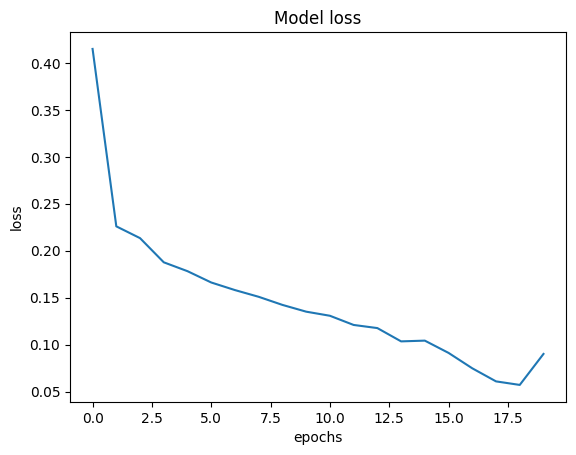

In [13]:
plt.plot(history.history['loss'])
plt.title("Model loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

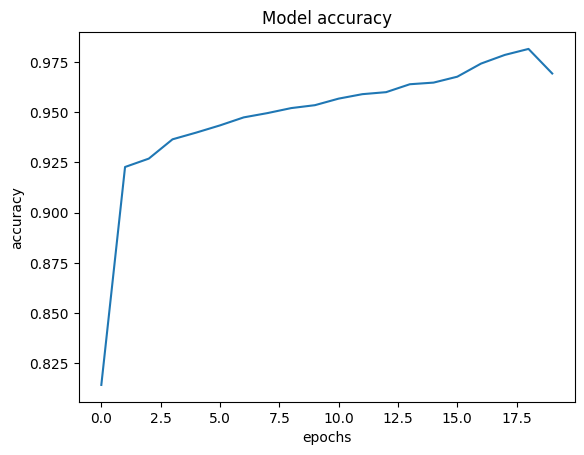

In [14]:
plt.plot(history.history['accuracy'])
plt.title("Model accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [15]:
model.evaluate(test_dataset)

86/86 [==============================] - 26s 26ms/step - loss: 0.2094 - accuracy: 0.9342


[0.209371879696846, 0.9342296719551086]